#  First Steps with BigWham 
### Solving the 2D Griffith crack problem 
[level- beginner]

Plane Elasticity problem 


In this notebook, we focus on the elasto-static problem of a straight fracture in an infinite isotropic medium under uniform remote tension.

We explore the different steps of the use of BigWham for the solution of crack problems in elasto-static in infinite media.

We first import the Bigwham python interface, as well as a different libraries 
(notably the scipy gmres for the solution of linear system via an iterative gmres algorithm).

In [1]:
# imports etc.
import sys
import os
home = os.environ["HOME"]
# append the path to Bigwham interface
sys.path.append("/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python")

from hmatrix import Hmatrix

import numpy as np
from scipy.sparse.linalg import gmres

# we import the reference solution for the Griffith crack problem.
sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import width_griffith

# for plotting
import matplotlib.pyplot as plt


We are interested in solving the elastic problem of a straigth crack $x_1 \in [-a,a]$ under remote uniform tension. The crack is aligned along the axis $\mathbf{e}_1$ with its normal being $\mathbf{e}_2$. 
The medium is considered infinite, with at infinity the following applied stress
$$
        \sigma_{11}^{\infty} = 0 \\
        \sigma_{22}^{\infty} =\sigma _{A} \\
        \sigma_{12}^{\infty} =0  \\
$$
while the crack is traction free, e.g. for $x_1 \in [-a,a]$ & $x_2=0$
$$
 \sigma_{22}(x_1,x_2=0) =t_2=  0 \\
 \sigma_{12}(x_1,x_2=0) =t_1 = 0 
 $$ 
By principle of superposition, the crack displacement discontinuity must balance the tractions due to the far-field stress $t_i^\infty$ such that ultimate traction on the crack face vanishes.

 The traction elasto-static boundary integral equations for such a case is given by:

 $$
        t_i(x_1,x_2) = t_i^\infty(x_1,x_2) - \int_{-a}^{a} H_{ij}(x_1,y_1) d_j \text{ d} y_1
 $$
 where $H_{ij}$ is the hyper-singular elastostatic kernel (dislocation dipole) and $d_i$ denotes the displacement discontinuity over the crack taken positive in overlap:
 $$
 d_i = u_i^- - u_i^+
 $$
 where the superscript $-$ and $+$ denotes the bottom and top surface of the crack, and $t_i$ denotes the traction vector with respect to the crack normal taken as the outward normal of the bottom surface of the crack $n_i=n_i^-$. 



### Discretization
In this first tutorial, we will solve the problem using piece-wise constant displacement discontinuity element. We first create a simple mesh for this problem - using a constant size for each element.
For simplicity, we take a crack of length 2, symmetrically with the origin.

Bigwham requires a 2D line mesh defined via two arrays. The first array contains the coordinates ($x_1,\,x_2$) of the vertex of the elements - we thus denote it as "coor" (its entries are typically float). The second array defines the "connectivity" of the mesh - for a 2D line mesh, each row consists of the number of the left and right vertex (where the number corresponds to the row of the coordinates array).

We use 20 elements for demonstration. There are thus 20+1=21 vertex.

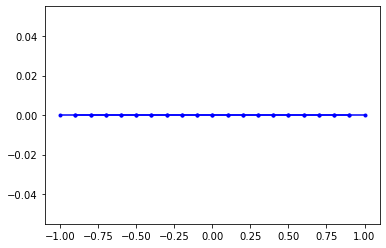

In [2]:
nelts=20
a=1
coor1D = np.linspace(-a, a, nelts + 1)  # the list of x coordinates of the element vertex
coor = np.transpose(np.array([coor1D, coor1D * 0.0])) # the y coordinates is all zero.
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_) # the connectivity of the mesh is very simple 

plt.plot(coor[conn[:],0],coor[conn[:],1],'.-b')

We set the elastic properties of the medium. Note that bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [3]:
G = 1.0                # shear modulus in [Pa]
nu = 0.25              # Poisson's ratio [-]
E = (2 * G) * (1 + nu) # Young's modulus [Pa]
elas_prop = np.array([E, nu]) # an array for the BigWham interface

With the mesh coordinates and connectivity in hand, and the elastic properties, we can initialize a hierarchical matrix object. 
Bigwham requires several additional information, notably  a string defining the type of element and elastic kernel to be used. For 2D elasto-static, to use P0 element (piece-wise constant displacement over the element), for the hyper-singular kernel the corresponding string value is "2DP0". (note - this will change soon and a _H will be required to select the hyper-singular kernel).

This 2D P0 element has its collocation point located at the center of the segment. 


In [38]:
kernel_elt = "2DP0"  # 2D elastic P0 element (piece-wise constant displacement discontinuity for fracture)


Bigwham uses a hierarchical matrix approach in order to compress the otherwise densily populated matrix. This is particularly efficient as the size of the mesh increases. For such a "tiny" mesh of 21 elements, there is no need to compress the resulting matrix. Neverheless we discuss here the 3 parameters controlling the compression of hiearchical matrix.

$\eta$ (eta in the code) controls the geometrical clustering  of groups of points between near-field and far-field interaction. The far-field interaction will be approximated as low-rank matrices. Setting a value of 0 ensures that NO compression will be performed. Otherwise, a value of 2 or 3 is a good starting point for an optimal compression.

max_leaf_size controls of the minimum size of a near-field / dense block of points. A good practice is to not have this too low, as if eta is large, a large number of "small" dense blocks will be created. A minimum of 32 is good practice. If the size of the mesh increases, it is efficient to increase the max_leaf_size (up to 2**9 or 2**10).

Finally, $\epsilon_{ACA}$ (eps_aca in the code) controls the accuracy of the low-rank approximation (by the adaptive cross approximation algorithm). A value of 1e-4 is a good starting value. 

In [39]:
eta = 0 #  here we ensure we do not compress at all (note eta can not be less than 0)
max_leaf_size=64
eps_aca = 1.e-4 

We can now instantiate a BigWham object - which here directly construct the collocation BEM hierarchical matrix of the elasto-static problem.

In [40]:
h = Hmatrix(kernel_elt, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

We can get the coordinates of the collocation points. And replot the mesh and the collocation points location, which are indeed at the middle of each elements.

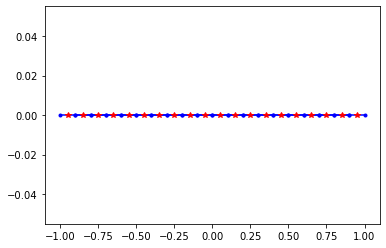

In [41]:
col_pts=h.getCollocationPoints()
col_pts[:,0]

plt.plot(coor[conn[:],0],coor[conn[:],1],'.-b')
plt.plot(col_pts[:,0],col_pts[:,1],'*r')

We can also check the spatial dimension of the problem via the method getSpatialDimension()

In [42]:
h.getSpatialDimension()

2

and that here, because of the choice of eta, no compression has been performed. The degree of compression is given as the ratio with respect to the otherwise dense matrix representation.

In [43]:
h.getCompression()

1.0

a value of 1 here indicates that we store the fully populated matrix.

Let's now solve the Griffith problem. We need to set the loading vector. The crack is free of traction, but we must cancel the effect of the far-field stress which is tensile. 


In [35]:

tinf = np.zeros(h.shape[0])

#  
tinf[1::2] = 1.

We are now ready to solve the linear system. We do so using an iterative method, with a pre-conditioner. A very good preconditioner can be constructed by taking an incomplete LU decomposition of the full blocks of the hierarchical matrix. 

In [36]:
jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h,tinf,M=jac_ilu,tol=1e-6)[0]
dd = d.reshape((-1, 2))

Text(0.5, 1.0, 'width(x)')

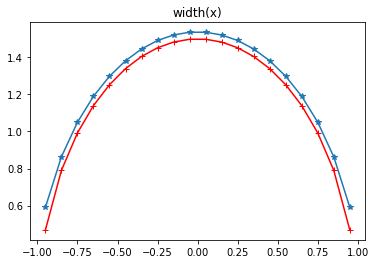

In [44]:
w_true=width_griffith(col_pts[:,0],a=1,sig=1,G=G,nu=nu)

plt.plot(col_pts[:,0], dd[:,1], "-*")
plt.plot(col_pts[:,0], w_true, "-+r") 
plt.title('width(x)')

## Increasing the number of elements in the mesh

In order to obtain a better solution (and to start playing with hierarchical matrix compression), we increase significantly the number of elements. From 20 elements, we now move to discretizing the crack with 1000 elements. To keep the computational cost tractable, we now use a value of 2 for $\eta$ (which controls the acceptability condition for low-rank approximation of "far-field" blocks).


In [45]:
nelts=1000
a=1
coor1D = np.linspace(-a, a, nelts + 1)  # the list of x coordinates of the element vertex
coor = np.transpose(np.array([coor1D, coor1D * 0.0])) # the y coordinates is all zero.
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_) # the connectivity of the mesh is very simple 

eta =2
h = Hmatrix(kernel_elt, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)


The hierarchical matrix has now large low-rank blocks. Of course, the diagonal dominant blocks corresponds to near-field effects & are thus not compressed: these blocks are full. We can visualize the pattern of the hierarchical matrix using the plotPattern() method. 
The compression ratio is now 0.23, which means that the hierachical representation store only 23% of the otherwise dense matrix.

-- Note: internally, BigWham performs a re-ordering of the degree of freedoms when creating the hierarchical tree via geometrical clustering. This is "hidden" from the python users, all the input & outputs are set in the original ordering corresponding to the mesh used in Python.

/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python/hmatrix.py:220: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


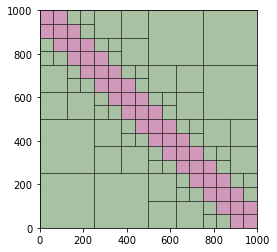

0.239184

In [47]:
h.plotPattern()
h.getCompression()

We can now similarly solve the problem. We use again an iterative solver - which is now mandatory as the hierarchical matrix can only perform matrix-vector product.

In [48]:
tinf = np.zeros(h.shape[0])
#  
tinf[1::2] = 1.

jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h,tinf,M=jac_ilu,tol=1e-6)[0]
dd = d.reshape((-1, 2))

Text(0.5, 1.0, 'width(x)')

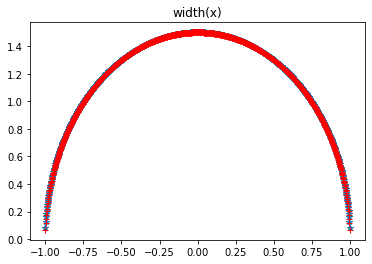

In [50]:
col_pts=h.getCollocationPoints()
w_true=width_griffith(col_pts[:,0],a=1,sig=1,G=G,nu=nu)

plt.plot(col_pts[:,0], dd[:,1], "-*")
plt.plot(col_pts[:,0], w_true, "+r") 
plt.title('width(x)')